### Imports

In [13]:
import os
import sys
import glob
import csv
import time
import platform
import socket
import random
import cv2
import re
from datetime import datetime
from tqdm.auto import tqdm
from typing import Tuple, List, Callable

In [14]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from dataclasses import dataclass

In [15]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.io import decode_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

### Constants

In [16]:
from displacements import VectorFieldComposer, VECTOR_FIELDS

TILES_DIR = "../tiles"
TILE_SIZE = 256

sequence_arrays = {}

# Iterate through sequence folders (e.g., "78", "g60")
for sequence_name in os.listdir(TILES_DIR):
    sequence_path = os.path.join(TILES_DIR, sequence_name)

    if os.path.isdir(sequence_path):  # Ignore hidden files/folders
        tile_arrays = {}  # Dictionary for tile arrays within this sequence

        # Iterate through image folders within the sequence (e.g., "0001.tif", "0023.tif")
        for image_folder_name in os.listdir(sequence_path):
            image_folder_path = os.path.join(sequence_path, image_folder_name)

            if os.path.isdir(image_folder_path):
                # Iterate through the tile images within the image folder
                for tile_image_name in os.listdir(image_folder_path):
                    if tile_image_name.startswith("tile_") and tile_image_name.endswith(".png"):
                        try:
                            tile_number_match = re.search(r"tile_(\d+)\.png", tile_image_name)
                            if tile_number_match:
                                tile_number = int(tile_number_match.group(1))
                                tile_image_path = os.path.join(image_folder_path, tile_image_name)
                                if tile_number not in tile_arrays:
                                    tile_arrays[tile_number] = []
                                tile_arrays[tile_number].append(tile_image_path)

                        except ValueError:
                            print(f"Warning: Could not parse tile number from {tile_image_name} in {image_folder_path}")



        sequence_arrays[sequence_name] = tile_arrays  # Add the tile arrays for this sequence


In [17]:
def stitch_tiles(tiles_data: dict, original_shape: tuple, tile_size: int) -> np.ndarray:
    """Stitch tiles back together with average blending in overlap regions.

    Args:
        tiles_data (dict): Dictionary where keys are tile numbers and values are tile data (numpy arrays).
        original_shape (tuple): Shape of the original image (height, width).
        tile_size (int): Size of each tile (assuming square tiles).

    Returns:
        np.ndarray: Stitched image.
    """
    height, width = original_shape
    result = np.zeros((height, width, 3), dtype=np.float32) # Assuming 3 channels for displacement field
    weights = np.zeros((height, width), dtype=np.float32)

    num_tiles_row = int(np.ceil(width / tile_size)) # Calculate number of tiles in a row

    for tile_number, tile_array in tiles_data.items():
        if not tile_array: # Skip empty tile lists (if any)
            continue
        tile_data = np.array(Image.open(tile_array[0])) / 255.0 # Load tile data from path and normalize. Assuming only one path in list now.
        tile_height, tile_width = tile_data.shape[:2] # Handle cases where tiles might be smaller at edges

        row_index = tile_number // num_tiles_row
        col_index = tile_number % num_tiles_row

        y_start = row_index * tile_size
        x_start = col_index * tile_size
        y_end = min(y_start + tile_height, height) # Use tile_height, tile_width instead of tile_size
        x_end = min(x_start + tile_width, width)

        tile_data_cropped = tile_data[:y_end - y_start, :x_end - x_start] # Crop tile data if necessary

        result[y_start:y_end, x_start:x_end] += tile_data_cropped
        weights[y_start:y_end, x_start:x_end] += 1


    mask = weights > 0
    result[mask] = result[mask] / weights[mask][..., np.newaxis] # Average by weights, keep channel dimension

    return (result * 255).astype(np.uint8) # Scale back to 0-255 and convert to uint8

# Model

In [18]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [19]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # i learned about this in class today! the timing in on point!
        return self.conv(x) + self.residual(x)

class MotionVectorRegressionNetwork(nn.Module):
    def __init__(self, input_images = 2):
        super().__init__()
        # Outputs an xy motion vector per pixel
        self.input_images = input_images
        self.vector_channels = 2

        self.convolution = nn.Sequential(
            ConvolutionBlock(input_images, 32, kernel_size=3), # input_images (2) -> 32 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(32, 64, kernel_size=3), # 32 -> 64 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(64, 128, kernel_size=3), # 64 -> 128 channels 
            ConvolutionBlock(128, 128, kernel_size=3), # 128 -> 128 channels
        ) 

        self.output = nn.Sequential(
            # scale back up
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 128 -> 64 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 64 -> 32 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, self.vector_channels, kernel_size=3, stride=1, padding=1), # 32 -> 2 channels
        )

    def forward(self, x):
        # print(x.shape)
        x = self.convolution(x)
        # print(x.shape)
        x = self.output(x)
        # print(x.shape)
        return x

model = MotionVectorRegressionNetwork(input_images=2).to(device)
print(model)

MotionVectorRegressionNetwork(
  (convolution): Sequential(
    (0): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0):

# Testing

In [20]:
# testin gthe model

MODEL_FILE = "model2/tx7.pth"

model = MotionVectorRegressionNetwork().to(device)
model.load_state_dict(torch.load(MODEL_FILE, weights_only=True))

<All keys matched successfully>

In [21]:
@dataclass
class Tile:
    data: np.ndarray
    position: Tuple[int, int]  # (y, x) position in original image
    size: int
    overlap: int

In [22]:
size: int = 256
overlap: int = 32
def create_tiles(image: np.ndarray) -> List[Tile]:
    """Split image into overlapping tiles."""
    height, width = image.shape
    tiles = []

    for y in range(0, height - overlap, size - overlap):
        for x in range(0, width - overlap, size - overlap):
            # Calculate tile boundaries
            y_end = min(y + size, height)
            x_end = min(x + size, width)
            
            # Extract tile data
            tile_data = image[y:y_end, x:x_end]
            
            # Pad if necessary
            if tile_data.shape != (size, size):
                padded_data = np.zeros((size, size), dtype=tile_data.dtype)
                padded_data[:tile_data.shape[0], :tile_data.shape[1]] = tile_data
                tile_data = padded_data
            
            tiles.append(Tile(
                data=tile_data,
                position=(y, x),
                size=size,
                overlap=overlap
            ))
            
    return tiles

In [23]:
def stitch_tiles(tiles: List[Tile], original_shape: tuple) -> np.ndarray:
    """Stitch tiles back together with average blending in overlap regions."""
    height, width = original_shape
    result = np.zeros(original_shape, dtype=np.uint8)
    weights = np.zeros(original_shape, dtype=np.float32)


    for tile in tiles:
        y, x = tile.position
        y_end = min(y + tile.size, height)
        x_end = min(x + tile.size, width)
        
        # Create weight mask for smooth blending
        weight_mask = np.ones((y_end - y, x_end - x), dtype=np.float32)
        
        # Apply feathering at edges
        if tile.overlap > 0:
            # Feather left edge
            if x > 0:
                weight_mask[:, :tile.overlap] = np.linspace(0, 1, tile.overlap)
            # Feather right edge
            if x_end < width:
                weight_mask[:, -tile.overlap:] = np.linspace(1, 0, tile.overlap)
            # Feather top edge
            if y > 0:
                weight_mask[:tile.overlap, :] *= np.linspace(0, 1, tile.overlap)[:, np.newaxis]
            # Feather bottom edge
            if y_end < height:
                weight_mask[-tile.overlap:, :] *= np.linspace(1, 0, tile.overlap)[:, np.newaxis]
        
        # Add weighted tile data
        result[y:y_end, x:x_end] += (tile.data[:y_end-y, :x_end-x] * weight_mask).astype(np.uint8)
        weights[y:y_end, x:x_end] += weight_mask
        
    # Normalize by weights to get final image
    mask = weights > 0
    result[mask] = (result[mask] * weights[mask]).astype(np.uint8)
    
    return result

(943, 1024)
(943, 1024)
(943, 1024, 3)
(943, 1024, 3)
(943, 1024, 3)


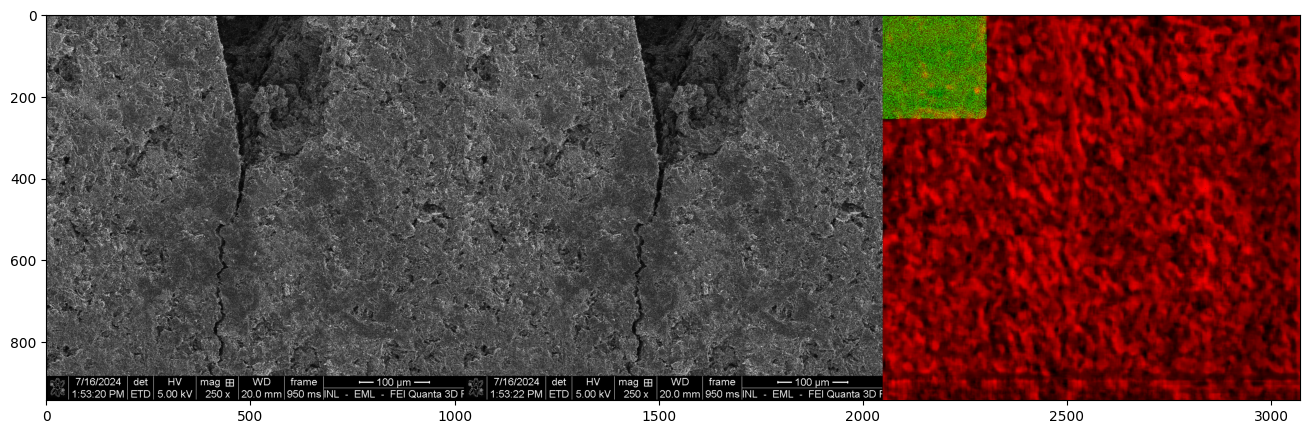

In [61]:
model.eval()

# print(sequence_arrays)
# sequence_array[sequence_name][tile index][time index]

sequence_name = 'g78'
mum_tiles = 41
# frames = [72, 73]
# num_tiles = len(sequence_arrays[sequence_name].keys())

# base_image_path = sequence_arrays['g78'][11][72]
# next_time_path = sequence_arrays['g78'][11][73]
RAW_DIR = "../raw"

image1_path = os.path.join(RAW_DIR, sequence_name, "00073.tif")
image2_path = os.path.join(RAW_DIR, sequence_name, "00074.tif")

# # '../tiles\\g78\\00074.tif\\tile_0.png'
# image1_tile_paths = glob.glob(os.path.join(TILES_DIR, sequence_name, "00073.tif", "*.png"))
# image2_tile_paths = glob.glob(os.path.join(TILES_DIR, sequence_name, "00074.tif", "*.png"))

# image1_tiles = np.stack([np.array(Image.open(tile_path), dtype=np.uint8) for tile_path in image1_tile_paths], axis=0)
# image2_tiles = np.stack([np.array(Image.open(tile_path), dtype=np.uint8) for tile_path in image2_tile_paths], axis=0)

# image_pairs = np.stack([image1_tiles, image2_tiles], axis=1)

# print(image_pairs.shape)

# image_pairs = torch.from_numpy(image_pairs).float().to(device)

# predictions = model(image_pairs)

# print(predictions.shape)

image1 = np.array(Image.open(image1_path), dtype=np.uint8)
image2 = np.array(Image.open(image2_path), dtype=np.uint8)

print(image1.shape)

image1_tiles = create_tiles(image1)
image2_tiles = create_tiles(image2)

out_tilesx = []
out_tilesy = []
with torch.no_grad():
    for i, tile1 in enumerate(image1_tiles):
        tile_position = tile1.position
        
        tile2 = image2_tiles[0]
        for tmptile in image2_tiles:
            if tile_position == tile2.position:
                tile2 = tmptile
                break
        
        stacked = np.stack([tile1.data, tile2.data], axis=0)
        # print(stacked.shape)

        batch = torch.from_numpy(np.array([stacked])).float().to(device)
        pred = model(batch)
        # print(pred.shape)

        converted_pred = pred[0].cpu().numpy()
        # converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
        converted_predx = converted_pred[0]
        converted_predx = (converted_predx - converted_predx.min()) / (converted_predx.max() - converted_predx.min())
        converted_predx = converted_predx * 256

        converted_predy = converted_pred[1]
        converted_predy = (converted_predy - converted_predy.min()) / (converted_predy.max() - converted_predy.min())
        converted_predy = converted_predy * 256

        out_tilesx.append(Tile(data=converted_predx, position=tile1.position, size=tile1.size, overlap=tile1.overlap))
        out_tilesy.append(Tile(data=converted_predy, position=tile2.position, size=tile2.size, overlap=tile2.overlap))

out_stichedx = stitch_tiles(out_tilesx, image1.shape)
out_stichedy = stitch_tiles(out_tilesy, image2.shape)

print(out_stichedx.shape)

out_st = np.stack((out_stichedx, out_stichedy, np.zeros(out_stichedx.shape)))
out_st = np.transpose(out_st, (1, 2, 0))

image1 = np.array((image1,) * 3)
image1 = np.transpose(image1, (1, 2, 0))
image2 = np.array((image2,) * 3)
image2 = np.transpose(image2, (1, 2, 0))

print(out_st.shape)
print(image1.shape)
print(image2.shape)

combined = np.hstack((image1, image2, out_st)).astype(np.uint8)

plt.figure(figsize=(20, 5))
plt.imshow(combined)
plt.show()

# base_image = np.array(Image.open(base_image_path))
# next_time = np.array(Image.open(next_time_path))

# with torch.no_grad():
#     X = torch.from_numpy(np.array([base_image, next_time])).float()
#     X = X.unsqueeze(0)
#     X = X.to(device)
#     pred = model(X)
    
#     converted_pred = pred[0].cpu().numpy()
#     converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
#     converted_pred = np.transpose(converted_pred, (1, 2, 0))
#     converted_pred = (converted_pred - converted_pred.min()) / (converted_pred.max() - converted_pred.min())

#     base_image = np.array((X[0, 0].cpu().numpy(),)*3)
#     base_image = np.transpose(base_image, (1, 2, 0))
#     next_time = np.array((X[0, 1].cpu().numpy(),)*3)
#     next_time = np.transpose(next_time, (1, 2, 0))
#     combined = np.hstack((base_image, next_time, converted_pred * 256)).astype(np.uint8)

#     print(combined.min(),combined.max())

#     plt.figure(figsize=(20, 5))
#     plt.imshow(combined)
#     plt.show()